In [1]:
import sys
sys.path.append('..')
from src.pomdp import *
from src.mdp import VI_Solver

import numpy as np

# POMDP Toy Problem

Symmetric 2 state, 2 action model

## Model definition

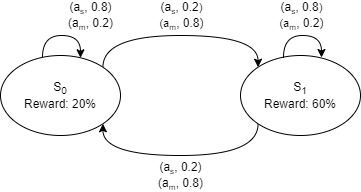

In [2]:
ACTION_COUNT = 2
STATE_COUNT = 2

In [3]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + a) % STATE_COUNT
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.8, 0.2],
       [0.2, 0.8]])

In [4]:
OBS_RND = 0.7 # 70% of observation success

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)
          
observation_table[:,0,:]

array([[0.7, 0.3],
       [0.3, 0.7]])

In [5]:
REWARD_PROBS = [0.2, 0.6]

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            reward_table[s,a,s_p] = REWARD_PROBS[s_p]
        
reward_table

array([[[0.2, 0.6],
        [0.2, 0.6]],

       [[0.2, 0.6],
        [0.2, 0.6]]])

In [6]:
states = ['s0','s1']
actions = ['stay', 'move']
observations = ['s0', 's1']

model = Model(states, actions, observations, transition_table, reward_table, observation_table, probabilistic_rewards=True)

## Solving

In [8]:
solver = PBVI_Solver(eps=0.001)

In [9]:
value_function, solve_history = solver.solve(model,9,10)

Converged early...


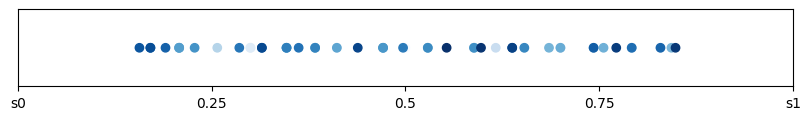

In [10]:
solve_history.plot_belief_set(10)

In [11]:
value_function

[AlphaVector([4.30520253, 4.54520253]),
 AlphaVector([4.54575168, 4.30450722]),
 AlphaVector([4.30450722, 4.54575168]),
 AlphaVector([4.30455718, 4.54572132]),
 AlphaVector([4.30046647, 4.54726038]),
 AlphaVector([4.54574629, 4.30451768]),
 AlphaVector([4.54726038, 4.30046647]),
 AlphaVector([4.54572132, 4.30455718]),
 AlphaVector([4.30451768, 4.54574629]),
 AlphaVector([4.27986007, 4.55231478]),
 AlphaVector([4.54520253, 4.30520253]),
 AlphaVector([4.54718662, 4.30069241]),
 AlphaVector([4.55231478, 4.27986007]),
 AlphaVector([4.30069241, 4.54718662]),
 AlphaVector([4.17186007, 4.57391478]),
 AlphaVector([4.57391478, 4.17186007]),
 AlphaVector([4.54571974, 4.30455933])]

<Figure size 600x400 with 0 Axes>

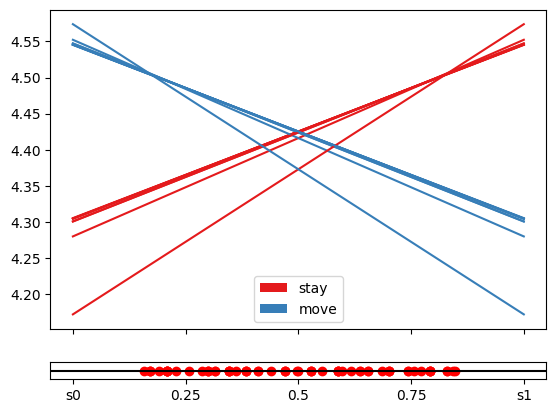

In [12]:
solve_history.plot_solution(4)

In [13]:
# solve_history.save_history_video()

## Simulation

In [14]:
agent = Agent(model)
agent.train(solver, 9, 10)

Converged early...


In [15]:
sim = Simulation(model)
rewards = agent.simulate(sim, 1000)

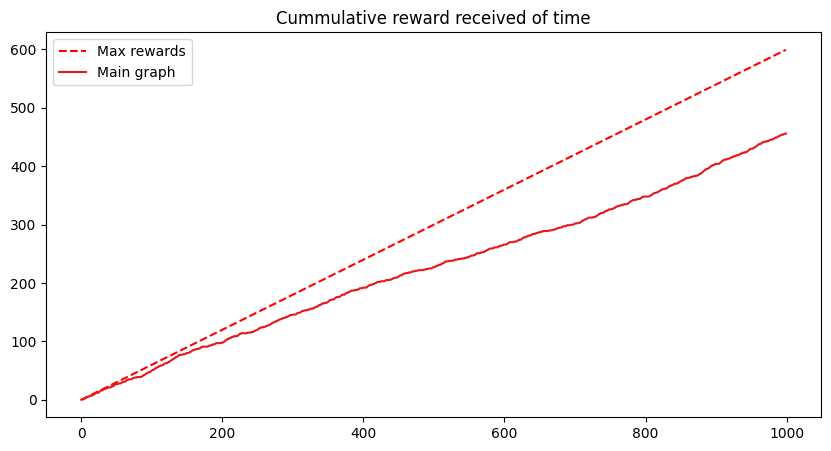

In [16]:
rewards.plot(type='total', max_reward=max(REWARD_PROBS))

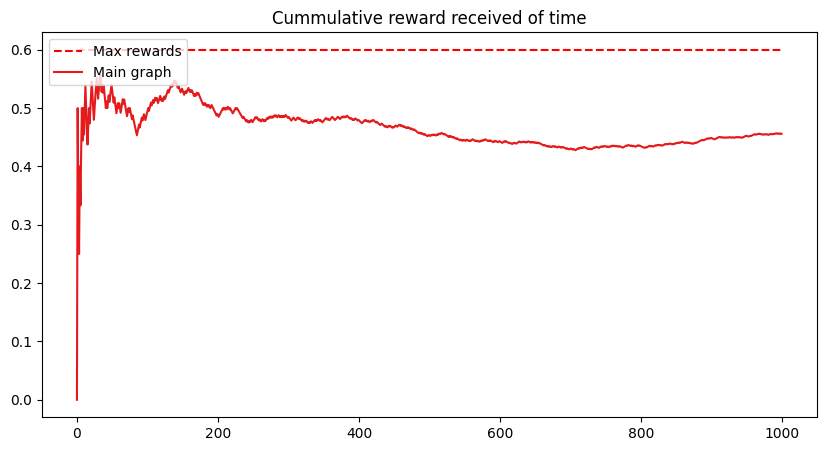

In [17]:
rewards.plot(type='moving_average', max_reward=max(REWARD_PROBS))

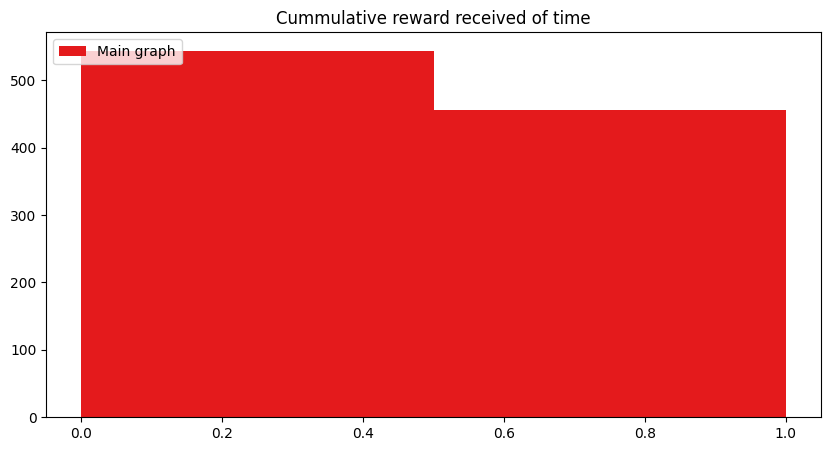

In [18]:
rewards.plot(type='histogram', max_reward=max(REWARD_PROBS))

## MDP Version of the probelm

In [19]:
vi_solver = VI_Solver(gamma=0.9)

In [20]:
vi_solution, vi_solve_history = vi_solver.solve(model)

In [20]:
# solve_history.save_history_video(custom_name='comparison', compare_with=vi_solve_history)

Video saved at 'Results/comparison-s2-a2-ssea-g0.9-e0.001-20230822_150536.mp4'...
